## Trigger Word Detection

Welcome to the final programming assignment of this specialization! 

In this week's videos, you learned about applying deep learning to speech recognition. In this assignment, you will construct a speech dataset and implement an algorithm for trigger word detection (sometimes also called keyword detection, or wakeword detection). Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word.  

For this exercise, our trigger word will be "Activate." Every time it hears you say "activate," it will make a "chiming" sound. By the end of this assignment, you will be able to record a clip of yourself talking, and have the algorithm trigger a chime when it detects you saying "activate." 

After completing this assignment, perhaps you can also extend it to run on your laptop so that every time you say "activate" it starts up your favorite app, or turns on a network connected lamp in your house, or triggers some other event? 

<img src="images/sound.png" style="width:1000px;height:150px;">

In this assignment you will learn to: 
- Structure a speech recognition project
- Synthesize and process audio recordings to create train/dev datasets
- Train a trigger word detection model and make predictions

Lets get started! Run the following cell to load the package you are going to use.    


In [0]:
# install google-drive-ocamlfuse 
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# create auth token for Colab
from google.colab import auth
auth.authenticate_user()

# create credential for Drive FUSE library
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# mkdir drive/  and mount Google Drive
!mkdir -p drive
!google-drive-ocamlfuse drive
!df -h drive
!ln -sfT "drive/Colab Notebooks" colab
!ls colab

In [0]:
!pip show tensorflow  # 1.6.0
!pip show keras  # 2.1.5

In [0]:
!apt install mlocate
# !apt install -y cuda-8.0
!apt install -y libsoxr-dev
!apt install -y libsndfile-dev
!pip install -r colab/requirements.txt

In [0]:
# !updatedb
!locate libcublas.so.9.0
!locate libcublas.so

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from tensorflow import set_random_seed

import pickle
import wave

In [ ]:
try:
    from colab.kr_model import *
    from colab.train_model import *
    from colab.kr_dataset import *
except:
    from kr_model import *
    from train_model import *
    from kr_dataset import *
%matplotlib inline

In [0]:
Tx = 1998 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [0]:
Ty = 496 # The number of time steps in the output of our model

## 1.4 - Full training set

You've now implemented the code needed to generate a single training example. We used this process to generate a large training set. To save time, we've already generated a set of training examples. 

In [0]:
# Load preprocessed training examples
X = np.load("./Triggerworddetection/XY_train/X.npy")
Y = np.load("./Triggerworddetection/XY_train/Y.npy")

In [0]:
print(X.shape)
print(Y.shape)

(26, 5511, 101)
(26, 1375, 1)


In [0]:
def load_dataset(filename):
    with open(filename, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        train_dataset = pickle.load(f)
    return train_dataset

In [0]:
#train_dataset['X']

In [0]:
#train_dataset['Y']

## 1.5 - Development set

To test our model, we recorded a development set of 25 examples. While our training data is synthesized, we want to create a development set using the same distribution as the real inputs. Thus, we recorded 25 10-second audio clips of people saying "activate" and other random words, and labeled them by hand. This follows the principle described in Course 3 that we should create the dev set to be as similar as possible to the test set distribution; that's why our dev set uses real rather than synthesized audio. 


In [0]:
# Load preprocessed dev set examples
X_dev = np.load("./Triggerworddetection/XY_dev/X_dev.npy")
Y_dev = np.load("./Triggerworddetection/XY_dev/Y_dev.npy")

In [0]:
print(X_dev.shape)
print(Y_dev.shape)

(25, 5511, 101)
(25, 1375, 1)


# 2 - Model

Now that you've built a dataset, lets write and train a trigger word detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers. Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

from tensorflow import set_random_seed

Using TensorFlow backend.


## 2.1 - Build the model

Here is the architecture we will use. Take some time to look over the model and see if it makes sense. 

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>

One key step of this model is the 1D convolutional step (near the bottom of Figure 3). It inputs the 5511 step spectrogram, and outputs a 1375 step output, which is then further processed by multiple layers to get the final $T_y = 1375$ step output. This layer plays a role similar to the 2D convolutions you saw in Course 4, of extracting low-level features and then possibly generating an output of a smaller dimension. 

Computationally, the 1-D conv layer also helps speed up the model because now the GRU  has to process only 1375 timesteps rather than 5511 timesteps. The two GRU layers read the sequence of inputs from left to right, then ultimately uses a dense+sigmoid layer to make a prediction for $y^{\langle t \rangle}$. Because $y$ is binary valued (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate."

Note that we use a uni-directional RNN rather than a bi-directional RNN. This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. If we used a bi-directional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip.  


Implementing the model can be done in four steps:
    
**Step 1**: CONV layer. Use `Conv1D()` to implement this, with 196 filters, 
a filter size of 15 (`kernel_size=15`), and stride of 4. [[See documentation.](https://keras.io/layers/convolutional/#conv1d)]

**Step 2**: First GRU layer. To generate the GRU layer, use:
```
X = GRU(units = 128, return_sequences = True)(X)
```
Setting `return_sequences=True` ensures that all the GRU's hidden states are fed to the next layer. Remember to follow this with Dropout and BatchNorm layers. 

**Step 3**: Second GRU layer. This is similar to the previous GRU layer (remember to use `return_sequences=True`), but has an extra dropout layer. 

**Step 4**: Create a time-distributed dense layer as follows: 
```
X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
```
This creates a dense layer followed by a sigmoid, so that the parameters used for the dense layer are the same for every time step. [[See documentation](https://keras.io/layers/wrappers/).]

**Exercise**: Implement `model()`, the architecture is presented in Figure 3.

In [0]:
# GRADED FUNCTION: model

def create_model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Activation("relu")(X)                                    # ReLu activation
    X = Dropout(0.8)(X)                                          # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)           # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                    # dropout (use 0.8)
    X = BatchNormalization()(X)                            # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)           # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                    # dropout (use 0.8)
    X = BatchNormalization()(X)                            # Batch normalization
    X = Dropout(0.8)(X)                                    # dropout (use 0.8)
    #X = Reshape((Ty*(128/NUM_CLASSES), NUM_CLASSES))(X)
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(NUM_CLASSES, activation = "softmax"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [0]:
model = create_model(input_shape=(Tx, n_freq))

NameError: name 'create_model' is not defined

Let's print the model summary to keep track of the shapes.

In [0]:
model.summary()

NameError: name 'model' is not defined

**Expected Output**:

<table>
    <tr>
        <td>
            **Total params**
        </td>
        <td>
           522,561
        </td>
    </tr>
    <tr>
        <td>
            **Trainable params**
        </td>
        <td>
           521,657
        </td>
    </tr>
    <tr>
        <td>
            **Non-trainable params**
        </td>
        <td>
           904
        </td>
    </tr>
</table>

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 at spectrogram to 1375. 

## 2.2 - Fit the model

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 26 examples. 

In [0]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [0]:
def train_model(model, dataset_filename):
    train_dataset = load_dataset(dataset_filename)
    X = train_dataset['X']
    Y = train_dataset['Y']
    print(X.shape)
    print(Y.shape)
    model.fit(X, Y, batch_size = 100, epochs=20)

In [ ]:
# Load audio segments using pydub 
raw_data = load_raw_audio(FEATURE_TYPE)

print("background len: " + str(len(raw_data.backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("number of keyword: " + str(len(raw_data.keywords.keys())))
print("keywords[0] len: " + str(len(raw_data.keywords['on'][0].audio)))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("keywords[1] len: " + str(len(raw_data.keywords['off'][0].audio)))     # Different "activate" clips can have different lengths 
# print(f"mean:{raw_data.mean} std:{raw_data.std}")


In [2]:
raw_data_path = 'raw_data_with_lfbe.pickle'
# raw_data_path = 'raw_data_with_mfcc.pickle'

In [0]:
with open(raw_data_path, 'wb') as f:
    pickle.dump(raw_data, f)

In [3]:
with open(raw_data_path, 'rb') as f:
    raw_data = pickle.load(f)

file:794cdfc5_nohash_0.wav start:87 end:639


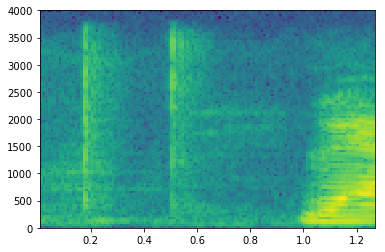

In [0]:
audio = raw_data.keywords['one'][4]
print(f"file:{audio.filename} start:{audio.start_ms} end:{audio.end_ms}")

filename = 'train/audio/one/' + audio.filename
graph_spectrogram(filename)
#plot_mfcc_feature('sample.wav')
IPython.display.Audio(filename)

In [0]:
audio = AudioSegment.from_wav(filename)
KeywordAudioData(audio, 'one', filename)

one
0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0
33: 0
34: 0
35: 0
36: 0
37: 0
38: 0
39: 0
40: 0
41: 0
42: 0
43: 0
44: 0
45: 0
46: 0
47: 0
48: 0
49: 0
50: 0
51: 0
52: 0
53: 0
54: 0
55: 0
56: 0
57: 0
58: 0
59: 0
60: 0
61: 0
62: 0
63: 0
64: 0
65: 0
66: 0
67: 0
68: 0
69: 0
70: 0
71: 0
72: 0
73: 0
74: 0
75: 0
76: 0
77: 0
78: 0
79: 0
80: 0
81: 0
82: 0
83: 0
84: 0
85: 0
86: 0
87: 1
88: 1
89: 1
90: 1
91: 1
92: 1
93: 1
94: 1
95: 0
96: 0
97: 0
98: 0
99: 0
100: 0
101: 1
102: 0
103: 0
104: 0
105: 1
106: 0
107: 0
108: 0
109: 0
110: 0
111: 0
112: 0
113: 0
114: 0
115: 0
116: 0
117: 0
118: 0
119: 0
120: 0
121: 0
122: 0
123: 0
124: 0
125: 0
126: 0
127: 0
128: 0
129: 0
130: 0
131: 0
132: 0
133: 0
134: 0
135: 0
136: 0
137: 0
138: 0
139: 0
140: 0
141: 0
142: 0
143: 0
144: 0
145: 0
146: 0
147: 0
148: 0
149: 0
150: 0
151: 0
152: 0
153: 0
154: 0
155: 0
156: 0
157: 0


In [25]:
from kr_model import *
from train_model import *
from kr_dataset import *

In [26]:
# model_cnn
model = build_model('model/kmn_cnn.weights.best.hdf5',
                    create_model=create_model_dilation_notd)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 198, 26)           0         
_________________________________________________________________
conv1d0 (Conv1D)             (None, 188, 200)          57400     
_________________________________________________________________
bn_conv1d0 (BatchNormalizati (None, 188, 200)          800       
_________________________________________________________________
activation_5 (Activation)    (None, 188, 200)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 188, 200)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 188, 400)          481200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 188, 400)          1600      
__________

In [ ]:
# model_cnn
np.random.seed(19)
set_random_seed(19)

for i in range(0, 2):
    print(f"num:{i}")
    train_model(model, raw_data, 'model/kmn_cnn.weights.best.hdf5',
                feature_type=FEATURE_TYPE)

In [9]:
# model_dilation_notd
model = build_model('model/kmn_dilation_lfbe.weights.best.hdf5',
                    create_model=create_model_dilation_notd)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 198, 26)           0         
_________________________________________________________________
conv1d0 (Conv1D)             (None, 188, 200)          57400     
_________________________________________________________________
bn_conv1d0 (BatchNormalizati (None, 188, 200)          800       
_________________________________________________________________
activation_3 (Activation)    (None, 188, 200)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 188, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 188, 400)          481200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 188, 400)          1600      
__________

In [ ]:
# model_dilation
np.random.seed(19)
set_random_seed(19)

for i in range(0, 2):
    print(f"num:{i}")
    train_model(model, raw_data, 'model/kmn_dilation_lfbe.weights.best.hdf5',
                feature_type=FEATURE_TYPE)

num:0
Epoch 1/20
500/500 [==============================] - 483s 965ms/step - loss: 1.8457 - acc: 0.3462 - val_loss: 1.2160 - val_acc: 0.5460

In [0]:
# model_ctc
model = build_model_ctc('model/kmn_ctc.weights.best.hdf5', create_model=create_model_ctc)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 999, 26)      0                                            
__________________________________________________________________________________________________
conv1d0 (Conv1D)                (None, 989, 200)     57400       the_input[0][0]                  
__________________________________________________________________________________________________
bn_conv1d0 (BatchNormalization) (None, 989, 200)     800         conv1d0[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 989, 200)     0           bn_conv1d0[0][0]                 
__________________________________________________________________________________________________
dropout_1 

In [0]:
# model_ctc
# np.random.seed(19)
# set_random_seed(19)
# for i in range(0, 5):
#     print(f"num:{i}")
#     train_model_ctc(model, backgrounds, keywords, 'model/kmn_ctc.weights.best.hdf5')

## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [2]:
from kr_model import *
from train_model import *
from kr_dataset import *


Using TensorFlow backend.


In [0]:
# model = create_model_ctc(input_shape=(Tx, n_freq), is_train=False, have_ctc=False)
# model.load_weights('model/kmn_ctc.weights.best.hdf5')
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 999, 26)           0         
_________________________________________________________________
conv1d0 (Conv1D)             (None, 989, 200)          57400     
_________________________________________________________________
bn_conv1d0 (BatchNormalizati (None, 989, 200)          800       
_________________________________________________________________
activation_1 (Activation)    (None, 989, 200)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 989, 200)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, 969, 200)          440200    
_________________________________________________________________
bn_conv1d1 (BatchNormalizati (None, 969, 200)          800       
__________

In [3]:
test_model = create_model_cnn2(input_shape=(Tx, n_freq), is_train=False)
test_model.load_weights('model/kmn_cnn2_lfbe.weights.best.hdf5')
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 199, 40)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 199, 40)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 199, 32)           6432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 199, 32)           128       
_________________________________________________________________
elu_1 (ELU)                  (None, 199, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 64)            10304     
__________

In [8]:
# wav = '/var/tmp/keyword_recognizer/noisered.wav'
# wav = 'test_up.wav'
# wav = 'test_stop_raw.wav'
# wav = 'test_stop_nr.wav'
wav = 'train/audio/sheila/850e2222_nohash_0.wav'
graph_spectrogram(wav)
#plot_mfcc_feature('sample.wav')
IPython.display.Audio(wav)

In [9]:
x = create_features(wav, FEATURE_TYPE)
if x.shape[0] < Tx:
    # calc remaining space size
    empty_space_size = Tx - x.shape[0]
    # create remaining space
    empty_space = np.zeros((empty_space_size, n_freq), dtype=np.float32)
    # complement data's empty space
    x = np.concatenate((x, empty_space), axis=0)
# frames = np.array(data)
x = np.float32(np.array([x]))
print(f"x:{x.shape},{x.dtype}")

predicted = test_model.predict(x)
print(f"pred:{predicted.shape} {predicted[0]}")
pred_y = np.argmax(predicted[0], axis=0)
print(pred_y)

x:(1, 199, 40),float32
pred:(1, 9) [  2.43608889e-09   6.94187824e-03   5.75241721e-09   1.23458277e-09
   1.02985723e-06   1.78676623e-06   5.03323972e-05   6.86251791e-04
   9.92318749e-01]
8


In [0]:
for i in range(0, 1):
    for idx, key_idx in enumerate(predicted[i]):
        #print([y == 0 for y in Y_dev[i]])
        # true_y = Y_dev[i][idx]
        pred_y = np.argmax(predicted[i][idx], axis=0)
        # if key_idx != predicted_selected[idx]:
        print(f"{idx} {(pred_y)}")

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 4
28 4
29 4
30 4
31 4
32 4
33 4
34 4
35 4
36 4
37 4
38 4
39 4
40 4
41 4
42 4
43 4
44 4
45 4
46 4
47 4
48 4
49 4
50 4
51 4
52 4
53 4
54 4
55 4
56 4
57 4
58 4
59 4
60 4
61 4
62 4
63 4
64 4
65 4
66 4
67 4
68 4
69 4
70 4
71 4
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0


In [0]:
for i in range(1):
    seed = i
    np.random.seed(seed)
    set_random_seed(seed)
    X_dev, Y_dev = create_dataset(backgrounds, keywords, is_train=False)
    # print(f"X_dev:{X_dev.shape} Y_dev:{Y_dev}")
    print(f"True transcription: {''.join(int_sequence_to_text(Y_dev))}")

    #print(f"inputshape:{np.expand_dims(X_dev, axis=0).shape}")
    prediction = model.predict(np.expand_dims(X_dev, axis=0))
    #print(f"predicted:{prediction.shape}, {prediction}")
    # output_length = [model.output_length(X_dev.shape[0])] 
    output_length = [969]
    #print(f"outputlength:{output_length}")
    ctc_decoded = keras_backend.ctc_decode(prediction, output_length)
    #print(f"ctc_decoded:{ctc_decoded} ctc_decoded[0][0]:{ctc_decoded[0][0]}")
    evaled = keras_backend.eval(ctc_decoded[0][0])
    #print(f"evaled:{evaled}")
    pred_ints = (evaled + 1).flatten().tolist()
    print('Predicted transcription:\n' + ''.join(int_sequence_to_text(pred_ints)))

#loss, acc = model.evaluate(X_dev, Y_dev)
#print("Dev set accuracy = ", acc)
#print("Dev set loss = ", loss)

True transcription: <SPACE>no<SPACE>right<SPACE>tree<SPACE>
Predicted transcription:
 og g f 


In [0]:
seed =5
np.random.seed(seed)
set_random_seed(seed)
X_dev, Y_dev = create_dataset(raw_data, 1, is_train=False, feature_type=feature_type)
print(f"X_dev:{X_dev.shape} Y_dev:{Y_dev.shape}")
# print(f"True transcription: {''.join(int_sequence_to_text(Y_dev))}")

X_dev:(1, 198, 26) Y_dev:(1, 188, 1)


In [0]:
predicted = model.predict(X_dev)
print(model.metrics_names)
model.evaluate(X_dev, Y_dev)

['loss', 'acc']
1/1 [==============================] - 0s 154ms/step


[0.042076345533132553, 0.98936170339584351]

In [0]:
# print(Y_dev)
# for i in range(len(Y_dev)):
for i in range(0, 1):
    for idx, key_idx in enumerate(Y_dev[i]):
        #print([y == 0 for y in Y_dev[i]])
        true_y = Y_dev[i][idx]
        pred_y = np.argmax(predicted[i][idx], axis=0)
        # if key_idx != predicted_selected[idx]:
        print(f"{idx} {(true_y, pred_y)}")

0 (array([ 0.]), 0)
1 (array([ 0.]), 0)
2 (array([ 0.]), 0)
3 (array([ 0.]), 0)
4 (array([ 0.]), 0)
5 (array([ 0.]), 0)
6 (array([ 0.]), 0)
7 (array([ 0.]), 0)
8 (array([ 0.]), 0)
9 (array([ 0.]), 0)
10 (array([ 0.]), 0)
11 (array([ 0.]), 0)
12 (array([ 0.]), 0)
13 (array([ 0.]), 0)
14 (array([ 0.]), 0)
15 (array([ 0.]), 0)
16 (array([ 0.]), 0)
17 (array([ 0.]), 0)
18 (array([ 0.]), 0)
19 (array([ 0.]), 0)
20 (array([ 0.]), 0)
21 (array([ 0.]), 0)
22 (array([ 0.]), 0)
23 (array([ 0.]), 0)
24 (array([ 0.]), 0)
25 (array([ 0.]), 0)
26 (array([ 0.]), 0)
27 (array([ 0.]), 0)
28 (array([ 0.]), 0)
29 (array([ 0.]), 0)
30 (array([ 0.]), 0)
31 (array([ 0.]), 0)
32 (array([ 0.]), 0)
33 (array([ 0.]), 0)
34 (array([ 0.]), 0)
35 (array([ 0.]), 0)
36 (array([ 0.]), 0)
37 (array([ 0.]), 0)
38 (array([ 0.]), 0)
39 (array([ 0.]), 0)
40 (array([ 0.]), 0)
41 (array([ 0.]), 0)
42 (array([ 0.]), 5)
43 (array([ 5.]), 5)
44 (array([ 5.]), 5)
45 (array([ 5.]), 5)
46 (array([ 5.]), 5)
47 (array([ 5.]), 5)
48

This looks pretty good! However, accuracy isn't a great metric for this task, since the labels are heavily skewed to 0's, so a neural network that just outputs 0's would get slightly over 90% accuracy. We could define more useful metrics such as F1 score or Precision/Recall. But let's not bother with that here, and instead just empirically see how the model does. 

# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [0]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

Once you've estimated the probability of having detected the word "activate" at each output step, you can trigger a "chiming" sound to play when the probability is above a certain threshold. Further, $y^{\langle t \rangle}$ might be near 1 for many values in a row after "activate" is said, yet we want to chime only once. So we will insert a chime sound at most once every 75 output steps. This will help prevent us from inserting two chimes for a single instance of "activate". (This plays a role similar to non-max suppression from computer vision.) 

<!-- 
**Exercise**: Implement chime_on_activate(). You will need to do the following:

1. Loop over the predicted probabilities at each output step
2. When the prediction is larger than the threshold and more than 75 consecutive time steps have passed, insert a "chime" sound onto the original audio clip

Use this code to convert from the 1,375 step discretization to the 10,000 step discretization and insert a "chime" using pydub:

` audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio.duration_seconds)*1000)
`
!--> 

In [0]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

## 3.3 - Test on dev examples

Let's explore how our model performs on two unseen audio clips from the development set. Lets first listen to the two dev set clips. 

In [0]:
IPython.display.Audio("./raw_data/dev/1.wav")